# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

Fraction of the total variance explained by the first  1 component:  16.40%
Fraction of the total variance explained by the first  2 components: 29.73% (difference = 13.32%)
Fraction of the total variance explained by the first  3 components: 39.90% (difference = 10.17%)
Fraction of the total variance explained by the first  4 components: 46.96% (difference =  7.06%)
Fraction of the total variance explained by the first  5 components: 50.83% (difference =  3.87%)
Fraction of the total variance explained by the first  6 components: 54.51% (difference =  3.68%)
Fraction of the total variance explained by the first  7 components: 57.64% (difference =  3.13%)
Fraction of the total variance explained by the first  8 components: 60.37% (difference =  2.73%)
Fraction of the total variance explained by the first  9 components: 62.99% (difference =  2.62%)
Fraction of the total variance explained by the first 10 components: 65.22% (difference =  2.23%)
Fraction of the total variance explained b

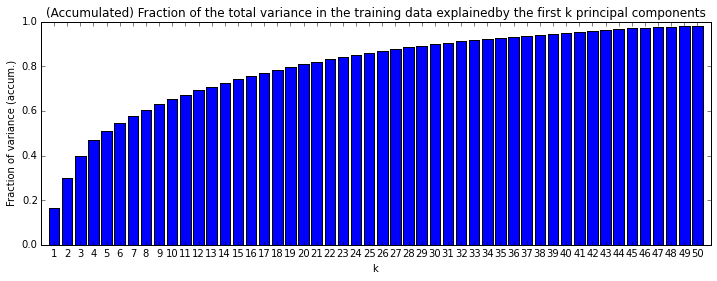

In [26]:
def P1():
### STUDENT START ###
    # Define Principal Components
    pc_all = PCA()
    # Find them for the training data
    pc_all.fit(train_data)
    # Show the fraction of the total variance in the training data explained by the firs k
        # components, for k in [1,50]
    K = 50
    partial_variance = pc_all.explained_variance_ratio_[:K].cumsum()
    for k in range(K):
        message_1 = 'Fraction of the total variance explained by the first'
        message_2singular = 'component: '
        message_2plural = 'components:'
        if k == 0:
            print '{0} {1:2} {2} {3:.2f}%'.format(message_1, k+1, message_2singular,
                                                  100*partial_variance[k])
        else:
            print '{0} {1:2} {2} {3:5.2f}% (difference = {4:5.2f}%)'.\
                format(message_1, k+1, message_2plural, 100*partial_variance[k],
                       100*(partial_variance[k]-partial_variance[k-1]))
        # First component explains 16.40% of the total variance, first 2 components up to
            # 29.73% (so the 2nd component alone explains 13.32% of the total variance), and
            # so forth, up to 98.21% (so the remaining 76 components explain less than 1.80%
            # of the variance)
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(1,51), partial_variance, align="center")
    plt.title('(Accumulated) Fraction of the total variance in the training data explained'\
              'by the first k principal components')
    plt.xticks(np.arange(1,51), np.array([str(i) for i in np.arange(1,51)]))
    plt.xlabel('k')
    plt.ylabel('Fraction of variance (accum.)')
    plt.axis([0, 51, 0, 1])
    plt.show()      
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

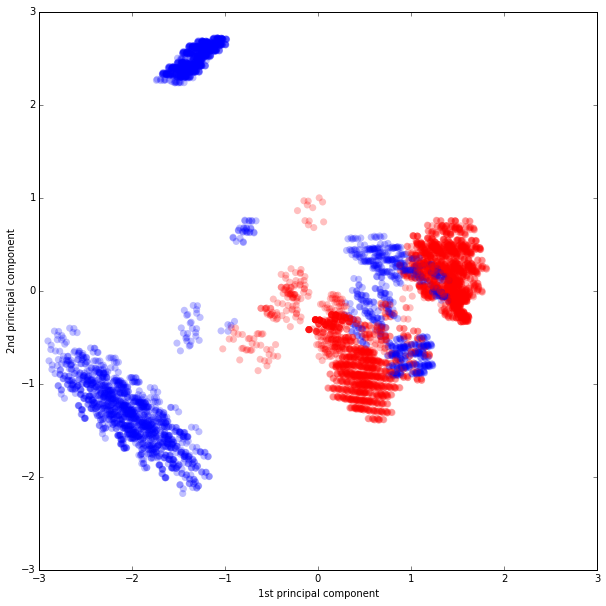

In [5]:
def P2():
### STUDENT START ###
    # Use only first 2 principal components
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    train_pc = pc_2.fit_transform(train_data)
    # Plot all elements of the training set in this 2-D space
    plt.figure(figsize=(10, 10))
    # Define an array of colors, blue or red depending on the train_label (1=poisonous, 0=not)
    colors = np.where(train_labels == 1, 'blue', 'red')
    # Plot each mushroom in the training set in the 2-D space, with its corresponding color
    # I've used semi-transparent colors to give a better idea of the areas with multiple
        # elements, and also to avoid one type of mushroom cover the other
    plt.scatter(train_pc[:,0], train_pc[:,1], c = colors, alpha = 0.25, s = 50, edgecolor='')
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.xlim([np.floor(train_pc.min()), np.ceil(train_pc.max())])
    plt.ylim([np.floor(train_pc.min()), np.ceil(train_pc.max())])
    # In purity I should have used
        # plt.xlim([np.floor(train_pc[:,0].min()), np.ceil(train_pc[:,0].max())])
        # plt.ylim([np.floor(train_pc[:,1].min()), np.ceil(train_pc[:,1].max())])
    # But I preferred to use same range for both scales
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

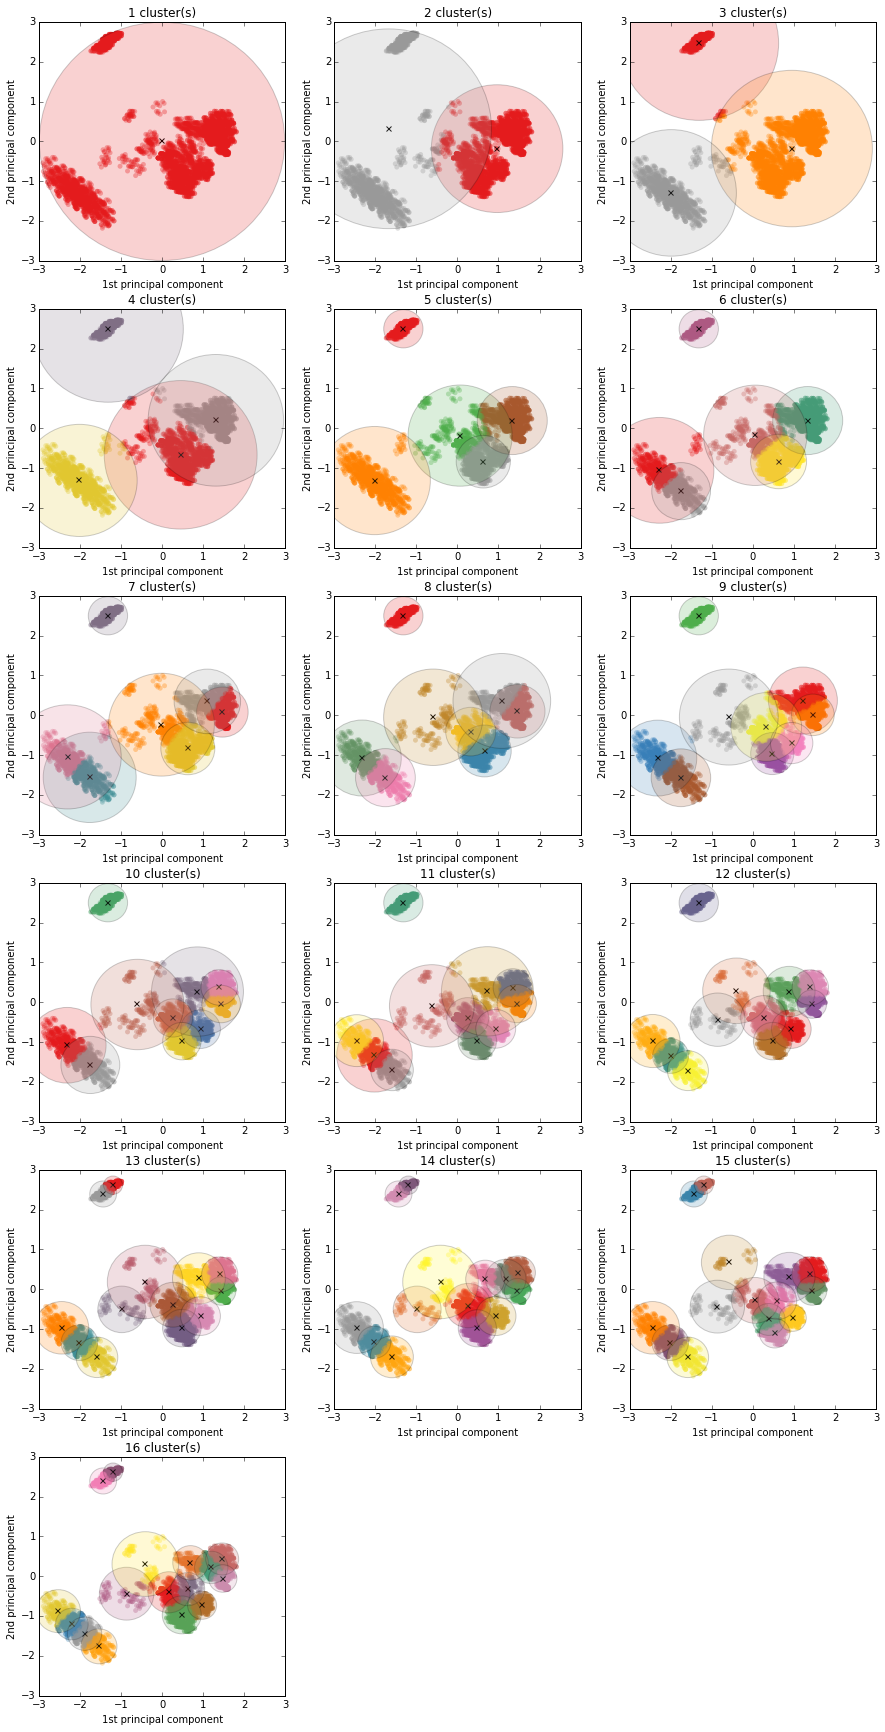

In [10]:
def P3():
### STUDENT START ###

    # Define a function that plot 1 to N k-means clusters for a 2-D dataset
    def plot2DClusters(X_2D, N):
        # Total size of the figure proportional to N (3 subfigures per row)
        plt.figure(figsize = (5*min(N,3), 5*int(np.ceil(N/3.))))
        for n in range(1,N+1):
            # Set number of clusters and initialize them
            km = KMeans(n_clusters=n, init='k-means++', max_iter=1000)
            # Fit to the data
            clstrs = km.fit (X_2D)
            # Each cluster will be plotted in a different color
            # I use one of the qualitative color palettes in matplotlib, equally spaced
            Colors = plt.cm.Set1(np.linspace(0, 1, n))
            # Each color is represented by 4 (RGBA) coordinates
            ClstrColors = np.empty(4*X_2D.shape[0]).reshape(X_2D.shape[0], 4)
            for i in np.arange (0, len(clstrs.labels_)):
                color_index = clstrs.labels_[i]
                # Each color is indexed by the number of the cluster
                ClstrColors[i,:] = Colors[color_index]
            # Plot each element in the dataset, each one with the color of the cluster it
                # belongs
            # n=1 in position (1,1), n=2 in position (1,2), n=3 in position (1,3), n=4 in
                # position (2,1), and so forth
            ax = plt.subplot(int(np.ceil(N/3.)), int(np.where(N/3>=1,3,n)), n)
            # Plot the observations of each cluster in its corresponding color
            plt.scatter (X_2D[:,0], X_2D[:,1], c = ClstrColors, alpha = 0.33, s=25,
                         edgecolor='')
            # Plot a circle centered in the centroid of each cluster, and whose radius is the
                # distance from that centroid to the most distant point in the corresponding
                # cluster
            for j in range(n):
                # For each of the n clusters:
                # Calculate the radius
                radius = metrics.euclidean_distances(clstrs.cluster_centers_[j,:],
                                                     X_2D[clstrs.labels_==j]).max()
                # Set the circle
                circle=plt.Circle(tuple(clstrs.cluster_centers_[j,:]), radius, clip_on=True)
                # Use the color assigned to that cluster
                circle.set_facecolor(Colors[j,:])  # 'None' for transparent background
                # Make it transparent (a bit more than the elements in the cluster)
                circle.set_alpha(0.2)
                # To be able to differentiate between circles, make borders black
                circle.set_edgecolor('black')
                # Add the circle to the plot
                plt.gca().add_artist(circle)
            # Plot the centroid of each cluster
            plt.scatter (clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1],
                         marker = 'x', c = 'black', s = 25)
            plt.title (str(n) + " cluster(s)")
            plt.xlabel("1st principal component")
            plt.ylabel("2nd principal component")
            plt.xlim([np.floor(X_2D.min()), np.ceil(X_2D.max())])
            plt.ylim([np.floor(X_2D.min()), np.ceil(X_2D.max())])        
    
    # Use only first 2 principal components
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    train_pc = pc_2.fit_transform(train_data)
    # Use the defined function
    plot2DClusters(train_pc, N=16)
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

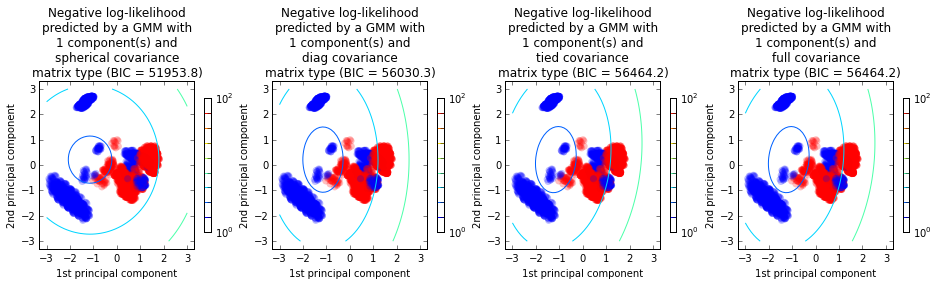

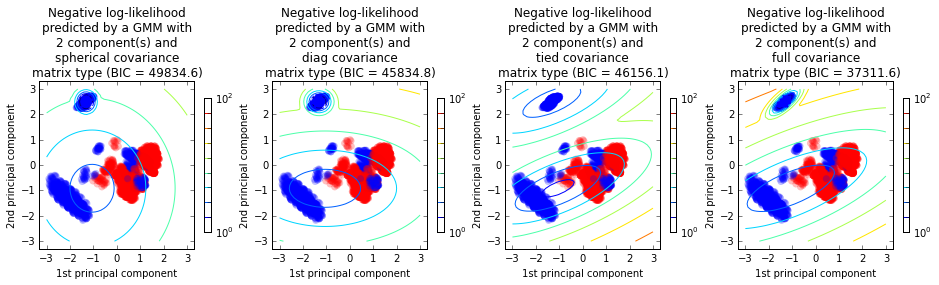

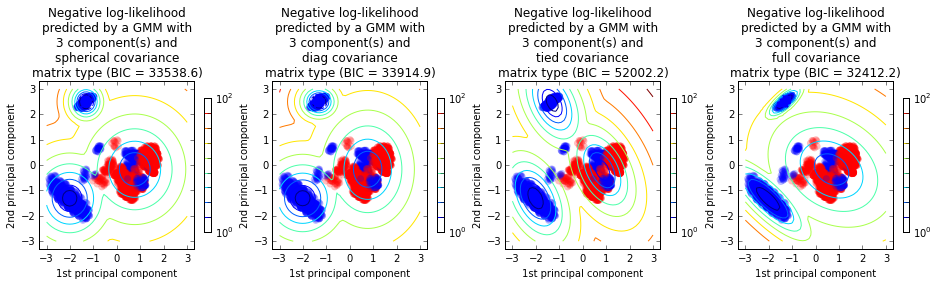

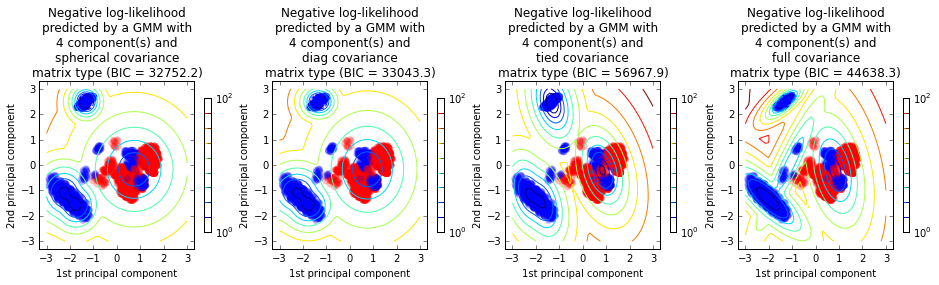

In [12]:
def P4():
### STUDENT START ###

    # Define a function that plot a number (comp) of Gaussian Mixtures, each with 1 or more
        # types of covariance matrix
    def plotGMM(X_2D, labels, comp, covar):
        # In case covar is not a list of strings but a single string, convert it to a list
        if not isinstance(covar, list):
            temp = []
            temp.append(covar)
            covar = temp
        # Total width of the figure proportional to the types of covariance matrices
        plt.figure(figsize = (4*len(covar), 3))
        for i,c in enumerate(covar):
            # Plot a (sub)figure for each type of covariance matrix
            gm = GMM(n_components=comp, covariance_type=c)
            # Fit the GM model to the positive examples
            gm.fit(X_2D[labels==1])
            # Display predicted scores by the model as a contour plot
            x = np.linspace(-3.0, 3.0)
            y = np.linspace(-3.0, 3.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)[0]
            Z = Z.reshape(X.shape)
            ax = plt.subplot(1, len(covar), i+1)
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 2, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            # Also both types of observations (positive/poisonous or not)
                # The Gaussian Mixtures should adapt to the positive/blue ones
            colors = np.where(labels == 1, 'blue', 'red')
            plt.scatter(train_pc[:,0], train_pc[:,1], c = colors, alpha = 0.25, s = 50,
                        edgecolor='')
            # Include information about the BIC in each plot's title
            plt.title('Negative log-likelihood\npredicted by a GMM with\n{0} component(s) and'
                      '\n{1} covariance\nmatrix type (BIC = {2:.1f})'.\
                      format(comp, c, gm.bic(X_2D)))
            plt.xlabel("1st principal component")
            plt.ylabel("2nd principal component")
            plt.axis('tight')

    # Use only first 2 principal components
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    train_pc = pc_2.fit_transform(train_data)
    # Create a row of figures for 1 to 5 mixture components, considering all possible types of
        # covariance matrix
    for comp in range(1,5):
        plotGMM(train_pc, train_labels, comp, ['spherical', 'diag', 'tied', 'full'])
    # Reminder:
    # spherical: (n_components, n_features)
        # Variance is the same along all axes and zero across-axes.
    # diag(onal): (n_components, n_features)
        # Each component has a diagonal covariance matrix (axes uncorrelated).
    # tied: (n_features, n_features)
        #  The same covariance matrix is shared by all the gaussians.
    # full: (n_components, n_features, n_features)
        # Gaussians with full covariance.

    # 1 or 2 mixture components are clearly not enough to differentiate the positive examples
        # from the negative, though at least with 2 mixture components we can isolate the
        # positive ones whose value of the 2nd PC is high (between 2 and 3).
    # With 3 mixture components we can also isolate the positive examples with a low value of
        # the 1st PC (around -2)
    # The problem with the remaining positive examples is that they're surrounded by negative
        # ones. With 4 mixture components, two of them are centered inside the group of
        # positive examples with the lowest values of the 1st PC (bottom left corner), unless
        # we use a full covariance matrix, in which case 3 of the mixture components are
        # centered in clusters of positive examples; the 4th mixture (right of the last figure)
        # almost does a nice work, but there are negative examples between 2 clustes of
        # positive ones that would also be predicted as positive
    
    # Based on the BIC, the best model is the one with 3 components and full covariance matrix,
        # followedby the models with 4 components and spherical or diagonal covariance matrix. 
        # The one with 4 components and full covariance matrix has a higher BIC because of the
        # increased complexity
### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [13]:
def P5():
### STUDENT START ###
    # Use only first 2 principal components
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    train_pc = pc_2.fit_transform(train_data)
    test_pc = pc_2.transform(test_data)
    # Create 2 GMMs
    gm_pos = GMM(n_components=4, covariance_type='full')
    gm_neg = GMM(n_components=4, covariance_type='full')
    # Fit each GMM to each kind of examples
    gm_pos.fit(train_pc[train_labels==1])
    gm_neg.fit(train_pc[train_labels==0])
    # Compute the log probabilities under each model
    logprob_pos = gm_pos.score(test_pc)
    logprob_neg = gm_neg.score(test_pc)
    # Predict the type of mushroom after comparing probabilities
    predictions = np.where(logprob_pos >= logprob_neg, 1, 0)
    # Print the accuracies
    print 'THE ACCURACY IS {0:.2f}%'.\
        format(100*metrics.accuracy_score(test_labels, predictions))
    # (True Positive + True Negative) / (Positive + Negative)
    # print metrics.classification_report(train_labels, predictions)
    # Print a table with the confusion matrix
    CM = metrics.confusion_matrix(test_labels, predictions)
    mushroom_type = [c.rjust(5) for c in map(str, np.unique(train_labels))]
    print "|    |{}|{}|".format(*mushroom_type)
    print '------------------'
    table = []
    for i,j in enumerate(np.unique(train_labels)):
        table.append([j, CM[i,0], CM[i,1]])
    for i in table:
        print "|{:4}|{:5}|{:5}|".format(*i)
    # I.e., the accuracy is (398+671)/1124.
### STUDENT END ###

P5()

THE ACCURACY IS 95.11%
|    |    0|    1|
------------------
|   0|  398|    8|
|   1|   47|  671|


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

**Let $F$ be the number of features or axes (PCA components), $C$ be the number of Gaussian Mixture components, and $L$ be the number of labels / classes / categories. The mean vector for each Gaussian Mixture component will always have $F$ different elements (so the mean will add $F \cdot C$ parameters per class: $F \cdot C \cdot L$ in total), but the number of parameters (i.e., the number of different elements) of the covariance matrices will depend on their type:**

* ***spherical*:**

    **For each Gaussian Mixture component, each feature (or axis) has the same variance, and the covariances are all zero, so this type of covariance matrix has $C$ parameters per class.**

$$\text{Parameters}_{\text{spherical}} = (F \cdot C + C) \cdot L = (F+1) \cdot C \cdot L$$

* ***diag*:**

    **For each Gaussian Mixture component, each feature (or axis) has its own variance, but the covariances are all zero, so this type of covariance matrix has $F \cdot C$ parameters per class.**

$$\text{Parameters}_{\text{diag}} = 2 \cdot F \cdot C \cdot L$$

* ***tied*:**

    **All the Gaussian Mixture components have the same covariance matrix. By default, a covariance matrix has $F \times F$ elements, but since $\sigma_{ij}=\sigma_{ji}, \forall i \neq j$, half of the non-diagonal elements are equal to the other half, and there are only $\frac{F^2-F}{2}+F=\frac{F^2+F}{2}=\frac{F\cdot(F+1)}{2}$ different elements in the matrix.**
    
$$\text{Parameters}_{\text{tied}} = \left(F \cdot C + \frac{F\cdot(F+1)}{2}\right) \cdot L = F \cdot \left(C + \frac{F+1}{2} \right) \cdot L$$

* ***full*:**

    **Same as the previous case, but each Gaussian Mixture component has its own covariance matrix, so we have to multiplyt by $C$.**

$$\text{Parameters}_{\text{spherical}} = \left(F \cdot C + \frac{F\cdot(F+1)}{2} \cdot C\right) \cdot L = F \cdot C \cdot \left(1 + \frac{F+1}{2} \right) \cdot L = F \cdot C \cdot \frac{F+3}{2} \cdot L$$

**I.e., for $L=2$:**
$$\text{P}_{\text{spherical}} = 2 \cdot (F+1) \cdot C$$
$$\text{P}_{\text{diag}} = 4 \cdot F \cdot C$$
$$\text{P}_{\text{tied}} = F \cdot (F + 2 \cdot C + 1)$$
$$\text{P}_{\text{full}} = F \cdot (F+3) \cdot C$$

In [14]:
def P6():
### STUDENT START ###
    # For covariance_type='spherical', num_parameters = 2*(F+1)*C
        # If num_parameters <= 50, F = 1 implies C <= 12, and C = 1 implies F <= 24
    # For covariance_type='diag', num_parameters = 4*F*C
        # If num_parameters <= 50, F = 1 implies C <= 12, and C = 1 implies F <= 12
    # For covariance_type='tied', num_parameters = F*(F+2*C+1)
        # If num_parameters <= 50, F = 1 implies C <= 24, and C = 1 implies F <= 5
    # For covariance_type='full', num_parameters = F*(F+3)*C
        # If num_parameters <= 50, F = 1 implies C <= 5, and C = 1 implies F <= 12
    # So F <= 24 and C <= 24
    F, C = np.meshgrid(np.arange(1, 25), np.arange(1, 26))
    cond_spherical = 2*(F+1)*C <= 50
    cond_diag = 4*F*C <= 50
    cond_tied = F*(F+2*C+1) <= 50
    cond_full = F*(F+3)*C <= 50
    conditions = [cond_spherical, cond_diag, cond_tied, cond_full]
    covar = ['spherical', 'diag', 'tied', 'full']
    best_accuracy = 0.0
    best_covar_type = None
    best_F = None
    best_C = None
    # An empty array to store each new case
    cases = np.empty((0,4))
    for i,cond in enumerate(conditions):
        # For the 4 possible types of covariance matrix
        for f,c in np.column_stack((F[cond],C[cond])):
            # For all values of F and C that satisfy the condition (num_parameters <= 50)
            # Use F features (principal components)
            pc_F = PCA(n_components=f)
            train_pc = pc_F.fit_transform(train_data)
            test_pc = pc_F.transform(test_data)
            # Create 2 GMMs, one per class, with C mixture components
            gm_pos = GMM(n_components=c, covariance_type=covar[i])
            gm_neg = GMM(n_components=c, covariance_type=covar[i])
            # Fit each GMM to the corresponding examples
            gm_pos.fit(train_pc[train_labels==1])
            gm_neg.fit(train_pc[train_labels==0])
            # Compute the log probabilities under each model
            logprob_pos = gm_pos.score(test_pc)
            logprob_neg = gm_neg.score(test_pc)
            # Predict the type of mushroom after comparing probabilities
            predictions = np.where(logprob_pos >= logprob_neg, 1, 0)
            # Calculate the accuracy
            acc = metrics.accuracy_score(test_labels, predictions)
            # Include new case
            cases = np.append(cases, np.array([[f, c, i, acc]]), axis=0)
            if acc > best_accuracy:
                best_accuracy = acc
                best_F = f
                best_C = c
                best_covar_type = covar[i]
    # Final result
    if best_covar_type == 'spherical':
        num_parameters = 2*(best_F+1)*best_C
    elif best_covar_type == 'diag':
        num_parameters = 4*best_F*best_C
    elif best_covar_type == 'tied':
        num_parameters = best_F*(best_F+2*best_C+1)
    elif best_covar_type == 'full':
        num_parameters = best_F*(best_F+3)*best_C
    print 'THE MODEL THAT GIVES THE BEST ACCURACY WITH NO MORE THAN 50 PARAMETERS USES'
    print '  {0} PCA COMPONENTS AND {1}-COMPONENT {2} COVARIANCE GMMs'.\
        format(best_F, best_C, best_covar_type.upper())
    print '  ({0} PARAMETERS EXACTLY) AND ITS ACCURACY IS {1:.2f}%\n'.\
        format(num_parameters, 100*best_accuracy)
    # Sort all cases (in descending order of the accuracy)
    cases = cases[cases[:, 3].argsort()[::-1], :]
    # Draw a table with all of them
    Results = [' Case', '  F', '  C', ' Covariance matrix type', ' Accuracy']
    print "\n|{}|{}|{}|{}|{}|".format(*Results)
    print '-------------------------------------------------'
    table = []
    for i,case in enumerate(cases):
        table.append([i+1, int(case[0]), int(case[1]), covar[int(case[2])].rjust(23), case[3]])
    for row in table:
        print "|{:5}|{:3}|{:3}|{}|{:9.4f}|".format(*row)
### STUDENT END ###

P6()

THE MODEL THAT GIVES THE BEST ACCURACY WITH NO MORE THAN 50 PARAMETERS USES
  7 PCA COMPONENTS AND 3-COMPONENT SPHERICAL COVARIANCE GMMs
  (48 PARAMETERS EXACTLY) AND ITS ACCURACY IS 97.33%


| Case|  F|  C| Covariance matrix type| Accuracy|
-------------------------------------------------
|    1|  7|  3|              spherical|   0.9733|
|    2|  5|  4|              spherical|   0.9689|
|    3|  4|  3|                   tied|   0.9680|
|    4|  6|  3|              spherical|   0.9680|
|    5|  5|  3|              spherical|   0.9662|
|    6|  3|  3|                   tied|   0.9635|
|    7|  5|  2|                   tied|   0.9600|
|    8|  3|  6|              spherical|   0.9600|
|    9|  3|  4|              spherical|   0.9591|
|   10|  4|  4|              spherical|   0.9582|
|   11|  3|  5|              spherical|   0.9555|
|   12|  4|  5|              spherical|   0.9537|
|   13|  2|  5|                   full|   0.9528|
|   14|  3|  4|                   tied|   0.9520|
|   15| 